In [12]:
import numpy as np
import pandas as pd
import scipy as sp
import json
import datetime
import statsmodels.api as sm
from pandas.io.json import json_normalize
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from matplotlib import pylab as plt
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, TimeSeriesResampler

In [13]:
def convert_datetime(name):
    json = pd.read_json('data/downloads/' + name + '_download.json')
    df_json = pd.DataFrame(json['downloads'])
    df = json_normalize(df_json['downloads'])
    df['day'] = pd.to_datetime(df['day'], infer_datetime_format=True)
    df.index = df['day']
    return df

def convert_week_datetime(name):
    df = convert_datetime(name)
    df_w = round(df.resample(rule="W").mean())
    return df_w

def convert_ts(name):
    df_w = convert_week_datetime(name)
    ts = sm.tsa.seasonal_decompose(df_w['downloads'].values, freq=52)
    return ts

def convert_normalize_array(name):
    ts = convert_ts(name)
    ts = ts.trend[26:131]
    d = TimeSeriesScalerMeanVariance(mu=0. , std=1.).fit_transform(ts)
    return d[0]

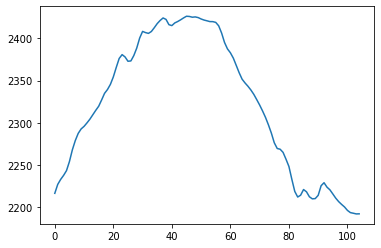

In [16]:
ts = convert_ts('express-generator')
train = ts.trend[26:131]
plt.plot(train)


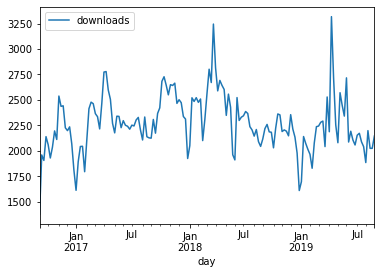

In [8]:
df = convert_week_datetime('express-generator')
df.plot()

In [17]:
TRAIN_SIZE = 20
TARGET_FUTURE = 5
WINDOW_SIZE =  TRAIN_SIZE + TARGET_FUTURE

def split_window_data(array, window_size):
    length = array.shape[0]
    roop_num = length - window_size + 1
    window_data = np.stack([
        np.hstack(
            np.array(array[i: i+window_size].astype('float64')).reshape(window_size, 1)
        )
        for i in range(roop_num)
    ])
    return window_data

window_data = split_window_data(train, WINDOW_SIZE)

In [ ]:
print(train.shape)
print(len(train))
print(window_data.shape)

In [18]:
print(window_data)

[[2216.25961538 2226.81730769 2232.75       ... 2376.23076923
  2380.78846154 2378.07692308]
 [2226.81730769 2232.75       2237.51923077 ... 2380.78846154
  2378.07692308 2372.93269231]
 [2232.75       2237.51923077 2243.19230769 ... 2378.07692308
  2372.93269231 2373.30769231]
 ...
 [2264.84615385 2256.76923077 2248.10576923 ... 2196.
  2193.39423077 2192.65384615]
 [2256.76923077 2248.10576923 2232.875      ... 2193.39423077
  2192.65384615 2191.83653846]
 [2248.10576923 2232.875      2218.51923077 ... 2192.65384615
  2191.83653846 2191.93269231]]


In [19]:
sc = StandardScaler()
window_sc = np.stack([
    np.hstack(sc.fit_transform(vec.reshape(WINDOW_SIZE, 1)))
    for vec in window_data
])

In [20]:
print(window_sc)

[[-1.78332007 -1.56700963 -1.44545813 ...  1.49423633  1.58761625
   1.53206111]
 [-1.75080622 -1.62528304 -1.52437624 ...  1.50689658  1.44952618
   1.34068518]
 [-1.80926639 -1.7048981  -1.58075034 ...  1.37102058  1.25844591
   1.26665229]
 ...
 [ 2.66657684  2.20777898  1.71566366 ... -1.2441287  -1.39214563
  -1.4342021 ]
 [ 2.6950076   2.13627108  1.15398625 ... -1.39226473 -1.44001469
  -1.49272568]
 [ 2.62530422  1.50580767  0.45062563 ... -1.45053959 -1.51061359
  -1.50354606]]


In [21]:
def curve_clustering(array, curve_len):
    train = np.stack([vec[0:curve_len] for vec in array])
    test = np.stack([vec[curve_len:] for vec in array])
    test_len = test.shape[1]
    
    # PCA
    pca = PCA(n_components=curve_len)
    pca.fit(train)
    
    # 共分散行列から写像
    cov_mtrx = pca.get_covariance()
    train_pca = np.dot(train, cov_mtrx)
    
    # あとで元に戻すため、共分散行列の逆行列を求めておく
    cov_mtrx_inverse = np.linalg.inv(cov_mtrx)

    # k-meansクラスタリング
    curve_clst_size = int(np.sqrt(train_pca.shape[0]/2))
    cls = KMeans(n_clusters=curve_clst_size, random_state=123)
    curve_clst = cls.fit_predict(train_pca)
    
    # クラスタ毎に、カーブのリスト、平均、分散、代表ベクトルを求めておく
    curve_df = pd.DataFrame({
        'curve_clst': curve_clst
        , 'train': [vec for vec in train]
        , 'train_pca': [vec for vec in train_pca]
    })
    for i in range(test_len):
        curve_df['test{}'.format(i)] = [vec[i] for vec in test]
    print([col for col in curve_df.columns if 'test' in col])
    curve_clst_dict = {
        cluster : {
            'test_means': [df[col].mean() for col in df.columns if 'test' in col]
            , 'test_medians': [df[col].median() for col in df.columns if 'test' in col]
            , 'test_stds': [df[col].std() for col in df.columns if 'test' in col]
            , 'train_cluster_center': np.dot(cls.cluster_centers_[cluster].flatten(), cov_mtrx_inverse)
            , 'train_pca_cluster_center': cls.cluster_centers_[cluster].flatten()
            , 'train_vectors': [vec for vec in df['train']]
            , 'train_pca_vectors': [vec for vec in df['train_pca']]
        }
        for cluster, df in curve_df.groupby('curve_clst')
    }
    return (curve_clst_dict, cls, pca)

curve_clst_dict, cls, pca = curve_clustering(window_sc, TRAIN_SIZE)

['test0', 'test1', 'test2', 'test3', 'test4']


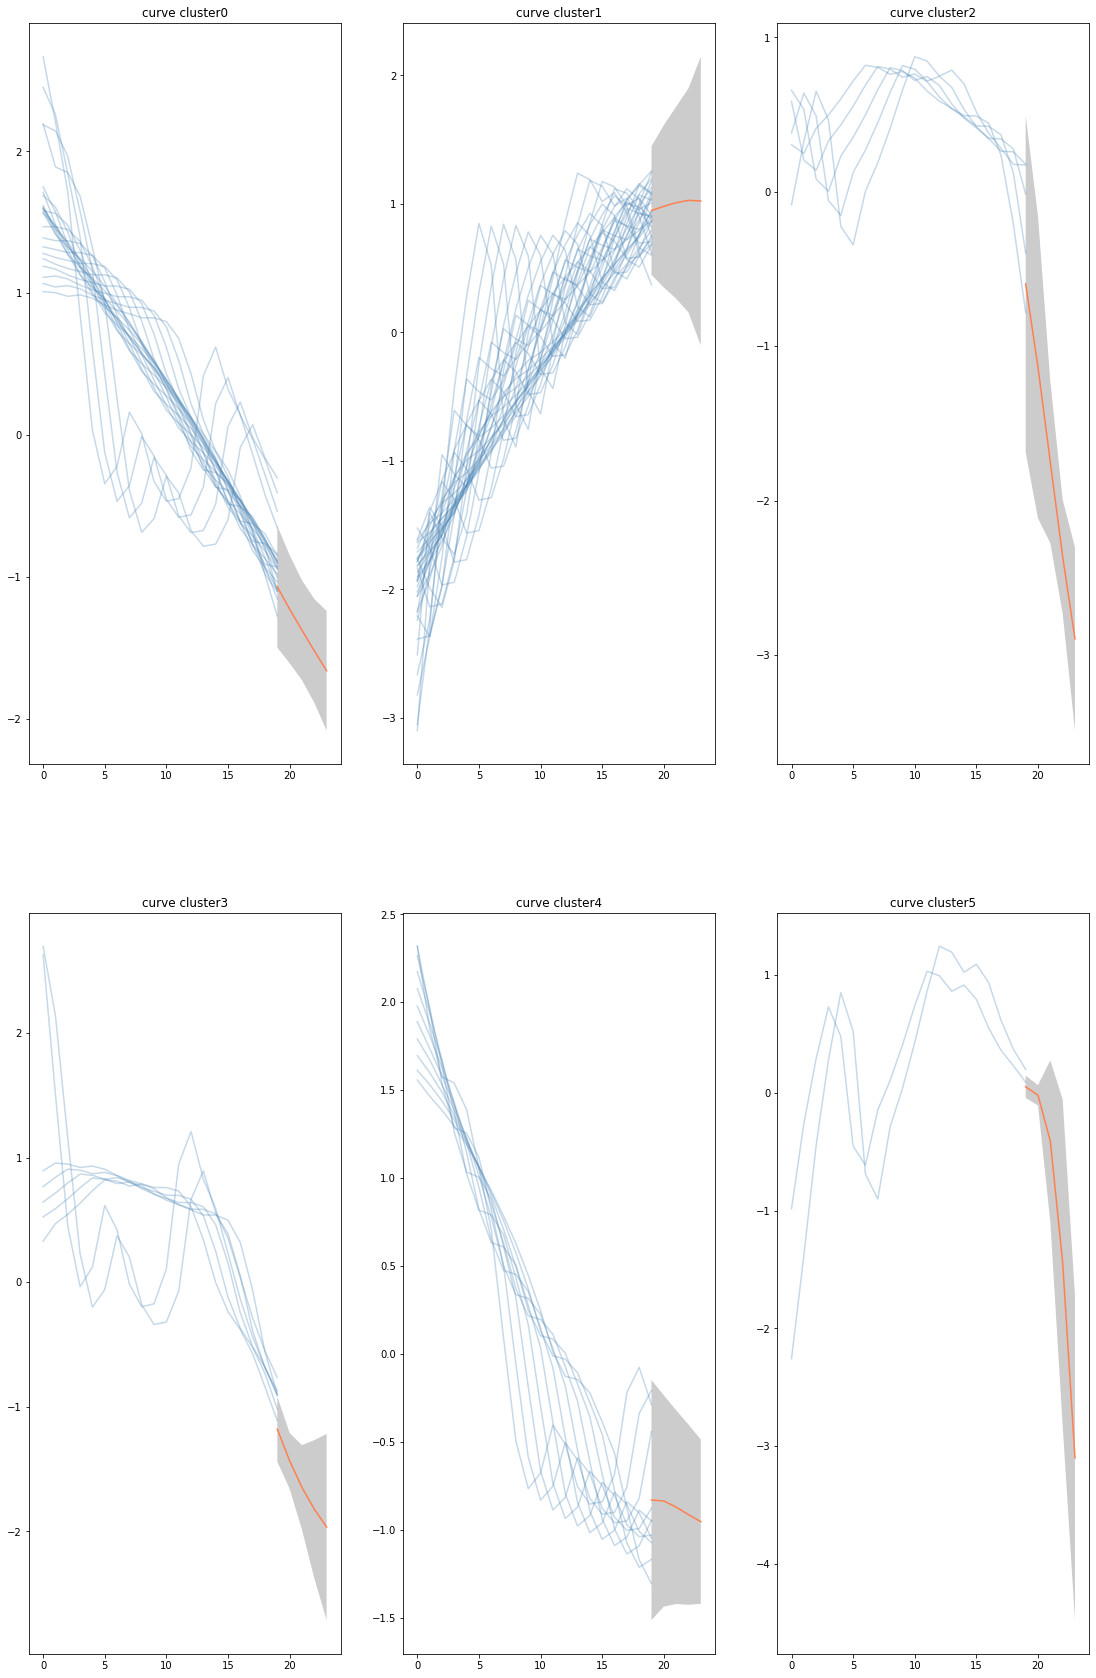

In [22]:
# グラフを行列形式で表示する
clst_size = len(curve_clst_dict)
row_size = int(clst_size/3) if clst_size%3 == 0 else int(clst_size/3) + 1
x_axis = [x for x in range(WINDOW_SIZE - 1)]

fig = plt.figure(figsize=(19,30))
for key in curve_clst_dict:
    # カーブのリストを取り出す
    clst_info = curve_clst_dict[key]
    raw_curves = clst_info['train_vectors']
    
    # subplotと行列番号の設定
    row_n = int(key/3)
    col_n = key%3
    ax = plt.subplot2grid((row_size,3), (row_n, col_n))
    
    # カーブのプロット
    for raw_curve in raw_curves:
        ax.plot(raw_curve, color='steelblue', alpha=0.3)
        
    # 区間のプロット
    upper_95 = np.hstack([np.repeat(np.nan, TRAIN_SIZE-1), np.array(clst_info['test_means']) + 2*np.array(clst_info['test_stds'])])
    lower_95 = np.hstack([np.repeat(np.nan, TRAIN_SIZE-1), np.array(clst_info['test_means']) - 2*np.array(clst_info['test_stds'])])
    ax.fill_between(x_axis, upper_95, lower_95, facecolor='gray', alpha=0.4)
    
    # 平均値のプロット
    ax.plot(list(np.repeat(np.nan, TRAIN_SIZE-1)) + list(clst_info['test_means']), color='coral')
    ax.set_title('curve cluster{}'.format(key))
plt.show()